In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import matplotlib.pyplot as plt

# Question 1:

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

- Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
- What metric would you report for this dataset?
- What is its value

### Importing Data

In [2]:
df_aov = \
    pd.read_csv('./2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv',
               parse_dates=['created_at'])

### Exploring the dataset
Printing the first 5 rows helps me get a glimpse at the dataset I am working with, to evaluate if anything seems wrong from the get-go. Reasonable values are in the columns specified like integers in columns that should have numbers (`order_id`, `order_amount`, etc.), string values that make sense for `payment_method`.

In [3]:
df_aov.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 04:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11


After viewing the data I think a useful column value here would be price per item. Since each shop only sells one model, this `price_per_item` is consistent within every shop.

In [4]:
# adding a new column to df_aov that is the calculated price per item.
df_aov.insert(5, 'price_per_item', df_aov['order_amount']/df_aov['total_items'])
df_aov.head()

,order_id,shop_id,user_id,order_amount,total_items,price_per_item,payment_method,created_at
0,1,53,746,224,2,112.0,cash,2017-03-13 12:36:56
1,2,92,925,90,1,90.0,cash,2017-03-03 17:38:52
2,3,44,861,144,1,144.0,cash,2017-03-14 04:23:56
3,4,18,935,156,1,156.0,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,156.0,credit_card,2017-03-01 04:35:11


Checking datatypes of each column. All the values that should be numbers are encoded as integers or floats, and the date is in datetime format.

In [5]:
df_aov.dtypes

order_id                   int64
shop_id                    int64
user_id                    int64
order_amount               int64
total_items                int64
price_per_item           float64
payment_method            object
created_at        datetime64[ns]
dtype: object

Understanding the size (number of entries, columns) of the dataframe

In [6]:
df_aov.shape

(5000, 8)

Checking for empty values in the dataframe, there are none

In [7]:
df_aov.isnull().values.any()

False

Checking for duplicate entries, there are none

In [8]:
df_aov.duplicated().values.any()

False

----
### First Glance Descriptive Statistics
The column from the provided dataset that we are interested in to reflect AOV, is `order_amount`. Looking at the statistical metrics of that column from `dataframe.describe()`, there are several things to notice:
- I can immediately see that the mean value of **\\$3145.13** is very different from the median value of **\\$284.00**.
    - This indicates that there are high outliers skewing the average of the dataset.
- This is corroborated by looking at the max value of `order_amount`, which is an extremely large value compared to the Q3 value.
- The max value of `total_items` is also very high.

**This one line of code uncovers that the naively calculated value came from taking the mean of a dataset with outliers, where taking the median would be more appropriate.**

In [9]:
descr = df_aov.describe()
round(descr, 2)

,order_id,shop_id,user_id,order_amount,total_items,price_per_item
count,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00
mean,2500.50,50.08,849.09,3145.13,8.79,387.74
std,1443.52,29.01,87.80,41282.54,116.32,2441.96
min,1.00,1.00,607.00,90.00,1.00,90.00
25%,1250.75,24.00,775.00,163.00,1.00,133.00
50%,2500.50,50.00,849.00,284.00,2.00,153.00
75%,3750.25,75.00,925.00,390.00,3.00,169.00
max,5000.00,100.00,999.00,704000.00,2000.00,25725.00


One way to find the mean of data with outliers is to find the trimmed mean, which simply trims the distribution from both tails and takes the mean. We will calculate a 5% trimmed mean, which will trim 10% of the data in total. This gives a mean much closer to the median value

In [10]:
trim = stats.trim_mean(df_aov['order_amount'], proportiontocut=0.05)
round(trim, 2)

294.39

Knowing there are outliers, let's look at a box-and-whiskers plot to examine some of these. I am looking at the data on two different y-scales. The linear scale makes it obvious there is a point or group of points much much larger than the rest of the data. But the log scale gives a better look at the other parts of the data since the high outlier values is so much larger than most of the other values):

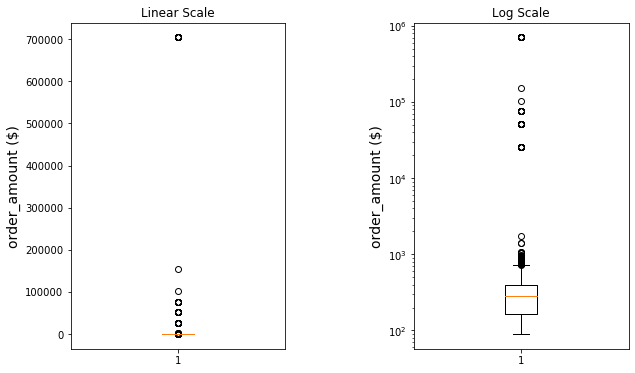

In [11]:
bxplt = plt.figure(figsize=(10,6))

bxplt.subplots_adjust(wspace=0.6)

ax1, ax2 = bxplt.add_subplot(1,2,1), bxplt.add_subplot(1,2,2)

ax1.boxplot(df_aov['order_amount'])
ax2.boxplot(df_aov['order_amount'])

ax2.set_yscale('log')

ax1.title.set_text('Linear Scale')
ax2.title.set_text('Log Scale')

ax1.set_ylabel(df_aov['order_amount'].name + ' ($)', fontsize=14)
ax2.set_ylabel(df_aov['order_amount'].name + ' ($)', fontsize=14)

plt.show()

### Outlier Exploration
I noticed that there is a group of outlier `order_amount` values > \\$10,000, so I decided to examine this subset of the data to make sure these data values reflect real inputs, and there aren't errors in the data set.

In [12]:
# make a dataframe of just order values >$10,000
df_outliers = df_aov[df_aov['order_amount']>=1e4]
print('values in outlier dataframe:',len(df_outliers))
df_outliers.head()

values in outlier dataframe: 63


,order_id,shop_id,user_id,order_amount,total_items,price_per_item,payment_method,created_at
15,16,42,607,704000,2000,352.0,credit_card,2017-03-07 04:00:00
60,61,42,607,704000,2000,352.0,credit_card,2017-03-04 04:00:00
160,161,78,990,25725,1,25725.0,credit_card,2017-03-12 05:56:57
490,491,78,936,51450,2,25725.0,debit,2017-03-26 17:08:19
493,494,78,983,51450,2,25725.0,cash,2017-03-16 21:39:35


All these outlier values come from two shops: 42 and 78. These values are not one-off outliers, but consistent within the shops. 

For example, from Shop 42 there are 17 orders (check `order_count`) for 2000 items totaling \\$704000 each. But, we can also see that the price per item is a high, but reasonable value of \\$352.

In Shop 78, the shoes seem to have a very high individual price of ~\\$25000. So either, this is an error in the price, or the shop sells some very boughie shoes. 


In total these outlier values make up >1% of the total orders.

In [13]:
dfo_group = df_outliers.groupby(['shop_id', 'order_amount'])

# add a column of the number of orders made at each order_value to understand uniqueness of outlier points
pd.concat([dfo_group.first(), dfo_group.count()['order_id'].rename('order_count')], axis=1)

order_id  user_id  total_items  price_per_item  \
shop_id order_amount                                                   
42      704000              16      607         2000           352.0   
78      25725              161      990            1         25725.0   
        51450              491      936            2         25725.0   
        77175             1260      775            3         25725.0   
        102900            2493      834            4         25725.0   
        154350             692      878            6         25725.0   

                     payment_method          created_at  order_count  
shop_id order_amount                                                  
42      704000          credit_card 2017-03-07 04:00:00           17  
78      25725           credit_card 2017-03-12 05:56:57           19  
        51450                 debit 2017-03-26 17:08:19           16  
        77175           credit_card 2017-03-27 09:27:20            9  
        102900                debit 2017-03-04 04:37:34            1  
        154350                debit 2017-03-27 22:51:43            1

I want to explore the rest of Shop 42's orders to see if they only consist of outlier value orders. What I find is that the high value orders make up ~1/3 of Shop 42's total orders, only a portion of the shop's total orders.

In [14]:
# make a dataframe of just Shop 42's orders
shop42 = df_aov[df_aov['shop_id'] == 42]
shop42_descr = shop42.groupby('order_amount')

# again add a column of the number of orders to see frequency of outliers in data
pd.concat([shop42_descr.agg(np.unique), shop42_descr.count()['order_id'].rename('order_count')], axis=1)

,shop_id,total_items,price_per_item,order_count
order_amount,,,,
352,42,1,352.0,15
704,42,2,352.0,13
1056,42,3,352.0,3
1408,42,4,352.0,2
1760,42,5,352.0,1
704000,42,2000,352.0,17


I also wanted to look at how Shop 78's very expensive model compares against other shops, and unsuprisingly, we find that shop 78 is by far the most expensive shoe (by two orders of magnitude).

In [15]:
pricehigh = df_aov.groupby('shop_id')['price_per_item'].agg(np.unique)
pricehigh.sort_values(ascending=False).head(10)

shop_id
78    25725.0
42      352.0
12      201.0
89      196.0
99      195.0
50      193.0
38      190.0
6       187.0
51      187.0
11      184.0
Name: price_per_item, dtype: float64

#### Trimmed mean for data with outliers
One way to find the mean of data with outliers is to find the trimmed mean, which simply trims the distribution from both tails and takes the mean. We will calculate a 5% trimmed mean, which will trim 10% of the data in total. This gives a mean much closer to the median value

In [16]:
trim = stats.trim_mean(df_aov['order_amount'], proportiontocut=0.05)
round(trim, 2)

294.39

#### Modified data set to reduce outliers

When I saw how much Shop 78's shoe model cost, I thought this could be a mistake where the price was inputted x100 larger than it was supposed to be (if the person logging it forgot the decimal for the cents). So I wanted to explore a data set where this value was modified, and the larger orders from Shop 42 were removed.

My first step in creating a modified data set was to correct this column and divide `order_amount` by \\$100 (as well as `price_per_item`). 

In [17]:
mod_dfaov = df_aov.copy()
for column in ['order_amount', 'price_per_item']:
    mod_dfaov.loc[mod_dfaov['shop_id'] == 78, column] = mod_dfaov[column]/100

The next step was to outright remove the extremely high order values from Shop 42 that are thousands of times larger than the median order value.

In [18]:
mod_dfaov = mod_dfaov[mod_dfaov['order_amount'] != 704000]

We can now see that the mean of this modified data set at **\\$304.33** is much closer to the median, indicating this data is not nearly as affected by the outliers.

In [19]:
mod_descr = mod_dfaov.describe()
round(mod_descr, 2)

,order_id,shop_id,user_id,order_amount,total_items,price_per_item
count,4983.00,4983.00,4983.00,4983.00,4983.00,4983.00
mean,2501.06,50.11,849.92,304.33,1.99,152.76
std,1443.09,29.05,86.80,163.04,0.98,30.61
min,1.00,1.00,700.00,90.00,1.00,90.00
25%,1250.50,24.00,776.00,163.00,1.00,133.00
50%,2502.00,50.00,850.00,284.00,2.00,153.00
75%,3750.50,75.00,925.00,390.00,3.00,168.00
max,5000.00,100.00,999.00,1760.00,8.00,352.00


## Problem Solution
The **\\$3145.13** value for AOV came from simply taking the average (mean) of the `order_count`, and from some analysis it has become clear that the dataset contains some high outlier values and is not normally distributed. In a dataset with outliers, the mean can be misleading. I see several ways to approach this problem: 

1. Take the median of the dataset, which is relatively unaffected by extreme data points. This requires us to make no assumptions and no changes to the data, which can sometimes be the best approach.

    In this case, the "average" order value would be **\\$284.00**.

2. Take the trimmed mean of the dataset. If taking the median is one extreme of trimming the data (only looking at the center value), then this can be interpreted as a comporomise between the mean and the median. We used a 5% trimmed mean.

    In this case, the "average" order value would be **\\$294.39**.

3. **Read below for note, this method has caveats.** Another way to go about it is to modify the data set. Above, I altered the values of Shop 78, assuming the values were imputted incorrectly and are x100 larger than they are supposed to be. Likewise, we could remove the very large orders from Shop 42, assuming these are outliers in the set and are confusing the average. We will use the mean of this new modified data set which is much closer to the median, a sign that the new data set is more normally distributed. 

    In this case, the "average" order value would be **\\$304.33**

    **NOTE:** Removing or modifying the outlier values here is not advised without more information. The very high value order from Shop 42 appeared 17 times over a 30 day period, and is most likely not a mistake. Likewise, the price per shoe for Shop 78 was extremely high, but the value was inputted repeatedly. Without the ability to prove that this value was some type of error, it is best to choose a statistic like median or trimmed mean that can guard against outliers without drastically modifying the data and potentially giving an unrealistic picture.

------
----
----
# Question 2: 

For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

### How many orders were shipped by Speedy Express in total?

~~~~mysql
SELECT COUNT(O.OrderID) AS NumOrders   
FROM Orders AS O JOIN Shippers AS S  
ON O.ShipperID=S.ShipperID  
WHERE S.ShipperName='Speedy Express'; 
~~~~
**value: 54**

### What is the last name of the employee with the most orders?

~~~~mysql
SELECT E.LastName, COUNT(O.EmployeeID) AS NumOrders  
FROM Employees AS E JOIN Orders AS O  
ON E.EmployeeID=O.EmployeeID  
GROUP BY E.LastName  
ORDER BY NumOrders DESC  
LIMIT 1;
~~~~

**value: Peacock, 40**

### What product was ordered the most by customers in Germany?
(I am interpreting this question to mean orders placed of a product, not total quantity of a product)

~~~~mysql
SELECT P.ProductName, COUNT(OD.ProductID) AS NumOrders  
FROM Products AS P JOIN OrderDetails AS OD  
ON P.ProductID=OD.ProductID  
JOIN Orders AS O ON O.OrderID=OD.OrderID  
JOIN Customers AS C ON C.CustomerID=O.CustomerID  
WHERE C.Country = 'Germany'  
GROUP BY P.ProductName  
ORDER BY NumOrders DESC  
LIMIT 1;  
~~~~

**value: Gorgonzola Telino, 5**